In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage import io, transform, exposure, filters, feature, color, data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from skimage import *
from sklearn.model_selection import train_test_split



In [2]:
IMG_SIZE = 224
NUMCLASSES = 53
BATCH_SIZE = 64

In [3]:
path = '../data/cards'
trainpath = path + '/train'
validationpath = path + '/valid'
testpath = path + '/test'
data = pd.read_csv(path + '/cards.csv')
data.head(10)

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
5,0,train/ace of clubs/006.jpg,ace of clubs,ace,train
6,0,train/ace of clubs/007.jpg,ace of clubs,ace,train
7,0,train/ace of clubs/008.jpg,ace of clubs,ace,train
8,0,train/ace of clubs/009.jpg,ace of clubs,ace,train
9,0,train/ace of clubs/010.jpg,ace of clubs,ace,train


In [4]:
trainfilelist = data[data['data set']=='train']
validfilelist = data[data['data set']=='valid']
testfilelist = data[data['data set']=='test']

print(trainfilelist.shape)
print(validfilelist.shape)
print(testfilelist.shape)

(7624, 5)
(265, 5)
(265, 5)


In [5]:
def preprocess(image):
    if len(image.shape)==2:
        image = np.stack([image,image,image],axis=2)
        
    image = np.float32(image)
    image = image - np.min(image)
    image = image / np.max(image)
    return image
    

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=True,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=True,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.0,
                                dtype=None,
                            )


In [7]:
# This next line is to use only some x% of the data, and shuffle
trainfilelist = trainfilelist.sample(frac=1.0)
validfilelist = validfilelist.sample(frac=1.0)
testfilelist = testfilelist.sample(frac=1.0)

trainfilelist.head()

,class index,filepaths,labels,card type,data set
6029,41,train/ten of clubs/092.jpg,ten of clubs,ten,train
6276,43,train/ten of hearts/047.jpg,ten of hearts,ten,train
7070,49,train/two of clubs/020.jpg,two of clubs,two,train
6447,44,train/ten of spades/089.jpg,ten of spades,ten,train
6608,45,train/three of clubs/092.jpg,three of clubs,three,train


In [8]:
training_set = train_datagen.flow_from_dataframe(
                                            dataframe=trainfilelist,
                                            directory=path,
                                            x_col="filepaths",
                                            y_col="labels",
                                            #weight_col=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe(
                                            dataframe=validfilelist,
                                            directory=path,
                                            x_col="filepaths",
                                            y_col="labels",
                                            #weight_col=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


In [9]:
model = Sequential()

model.add(InputLayer(input_shape=[IMG_SIZE,IMG_SIZE,3])) #keras will internally add batch dimension
# Convolutional part
model.add(Conv2D(filters=32,kernel_size=7,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=3,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())
# Fully connected part
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(NUMCLASSES,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 38, 38, 64)        0

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])


In [11]:
# num_epochs = 10
# history = model.fit(training_set, epochs=num_epochs, validation_data=validation_set)

# model.save_weights("model-cards_"+str(num_epochs+60)+".weights.h5")
# print("Saved model to disk after",num_epochs,"epochs.")

model.load_weights('model-cards_70.weights.h5')

In [31]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

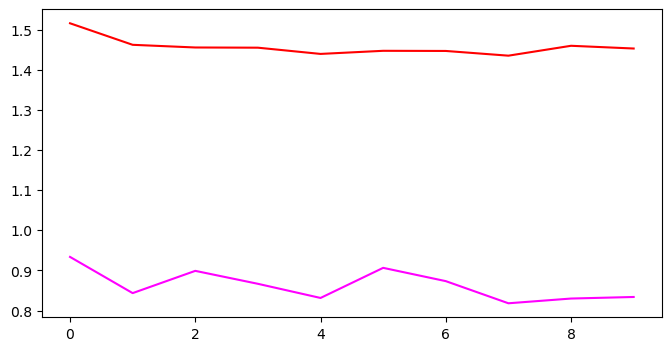

In [33]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
# plt.plot(history.history['acc'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
# plt.plot(history.history['val_acc'],color='blue')
plt.show()

1/1 [==============================] - 0s 16ms/step
Real class: five of spades
Predictions:
five of spades : 0.043687753
five of hearts : 0.038395192
four of clubs : 0.03789859
six of clubs : 0.036263466
five of clubs : 0.03549671


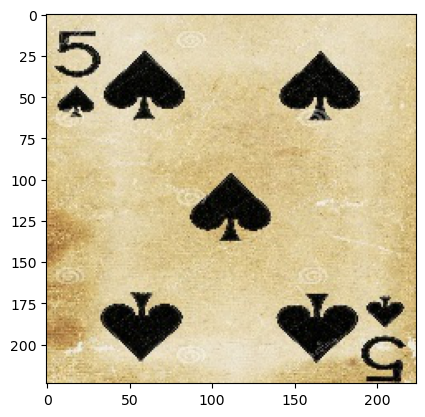

In [16]:
# Get random image
i = np.random.randint(len(testfilelist))
image_path = path + '/' + testfilelist.iloc[i,1]
image = io.imread(image_path)
label = testfilelist.iloc[i,2]
plt.imshow(image)

# Prepare image
img = transform.resize(image,(IMG_SIZE,IMG_SIZE))
img = preprocess(image)
img_tensor = np.expand_dims(img, axis=0)

# Print what the top predicted class is
#print(img_tensor.shape)
preds = model.predict(img_tensor)
preds = preds.flatten()
#print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', label)
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])


In [17]:
test_set = train_datagen.flow_from_dataframe(
                                            dataframe=testfilelist,
                                            directory=path,
                                            x_col="filepaths",
                                            y_col="labels",
                                            #weight_col=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

Found 265 validated image filenames belonging to 53 classes.


5/5 [==============================] - 1s 230ms/step
Real class: queen of clubs	Prediction: queen of clubs
Real class: ace of hearts	Prediction: ace of hearts
Real class: three of diamonds	Prediction: three of diamonds
Real class: six of spades	Prediction: six of spades
Real class: ten of hearts	Prediction: ten of hearts
Real class: two of hearts	Prediction: two of hearts
Real class: jack of hearts	Prediction: jack of hearts
Real class: seven of diamonds	Prediction: seven of diamonds
Real class: king of diamonds	Prediction: king of diamonds
Real class: jack of spades	Prediction: jack of spades
Real class: five of hearts	Prediction: five of hearts
Real class: two of clubs	Prediction: two of clubs
Real class: ten of diamonds	Prediction: ten of diamonds
Real class: five of clubs	Prediction: five of clubs
Real class: two of spades	Prediction: two of spades
Real class: three of diamonds	Prediction: three of diamonds
Real class: seven of clubs	Prediction: seven of clubs
Real class: ace of di

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5.])

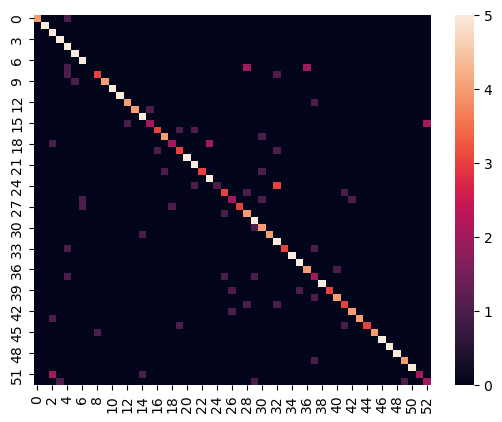

In [18]:
import seaborn as sn

testset = test_set

predictions = model.predict(testset)

order = np.argsort(predictions,1)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts    

<Axes: >

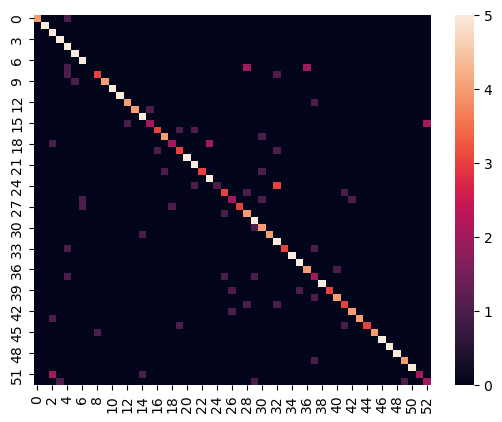

In [19]:
sn.heatmap(conf)


# Now we visualize response maps

In [20]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['conv2d', 'max_pooling2d', 'dropout', 'conv2d_1', 'max_pooling2d_1', 'dropout_1', 'conv2d_2', 'max_pooling2d_2', 'dropout_2', 'conv2d_3', 'max_pooling2d_3', 'dropout_3', 'flatten', 'dense', 'dropout_4', 'dense_1', 'dropout_5', 'dense_2']


In [21]:
img_size = (IMG_SIZE,IMG_SIZE,3)

last_conv_layer_name = "conv2d_3"
classifier_layer_names = ['max_pooling2d_3', 'dropout_3', 'flatten', 'dense', 'dropout_4', 'dense_1', 'dropout_5', 'dense_2' ]


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


# def get_img_array(img_path,size):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=(trainImagesX.shape[1], trainImagesX.shape[2]))
#     img /= np.amax(img)
#     img_tensor = tf.keras.preprocessing.image.img_to_array(img)
#     img_tensor = np.expand_dims(img_tensor, axis=0)
#     #img_tensor /= 255.
#     return img_tensor
        


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)


    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as gt:
        # Compute activations of the last conv layer and make the gt watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        gt.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = gt.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap)+np.finfo(float).eps)
    return heatmap



1/1 [==============================] - 0s 17ms/step
Real class: ace of clubs
Predictions:
four of clubs : 0.058560997
eight of clubs : 0.049248748
two of clubs : 0.04833456
six of clubs : 0.045571093
five of clubs : 0.04468435


/var/folders/ml/3g69gnf93h98jdphzcp35nmm0000gn/T/ipykernel_82558/1251714485.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


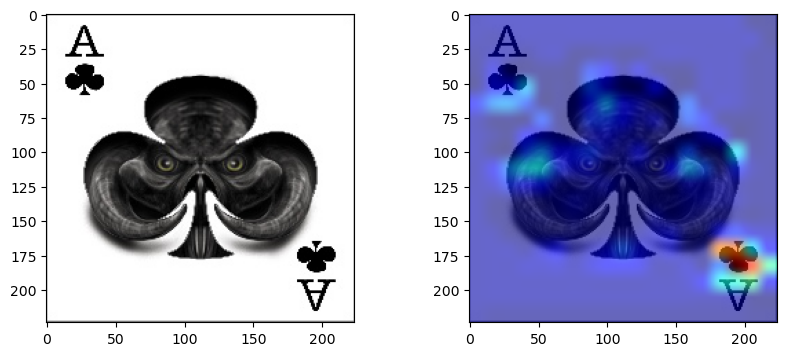

In [29]:
import matplotlib.cm as cm

# Get random image
i = np.random.randint(len(testfilelist))
image_path = path + '/' + testfilelist.iloc[i,1]
image = io.imread(image_path)
label = testfilelist.iloc[i,2]
# plt.imshow(image)
image_copy = np.copy(image)

# Prepare image
img = transform.resize(image,(IMG_SIZE,IMG_SIZE))
img = preprocess(image)
img_tensor = np.expand_dims(img, axis=0)

# Print what the top predicted class is
#print(img_tensor.shape)
preds = model.predict(img_tensor)
preds = preds.flatten()
#print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', label)
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, classifier_layer_names)
# plt.imshow(heatmap)
        
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image_copy.shape[1], image_copy.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap*0.6 + image_copy*0.4
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
fig = plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.imshow(image_copy)
plt.subplot(1,2,2)
plt.imshow(superimposed_img)
